# Text Analysis for Demography
*Ian Kennedy*  
University of Washington

This notebook works through a couple python examples of text analysis using a small set of scraped craigslist data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
%matplotlib inline

In [2]:
# we read the csv data
df = pd.read_csv('data/seattle_sample_demog.csv',index_col=0,dtype = {'GEOID10':object,'blockid':object, 'postID':object})
df['high_white'] = df.white_proportion > np.median(df.white_proportion)

# then look at it, seems like a lot of fields
df.head()

,cleanRent,cleanSqft,cleanBeds,lat,lng,GEOID10,seattle,listingTitle,listingText,cleanText,...,latinx_proportion,all_other_proportion,pov_proportion,pop_thousands,share_oo,share_rental_over_20,share_built_after_10,share_commuters,share_college,high_white
postID,,,,,,,,,,,,,,,,,,,,,
post id: 6571302181,1900,1536,3,47.506616,-122.515246,53035092704,0.0,"3 Bd, 2 Bath home 1 mile from Southworth Ferry!",\nDesirable Southworth area 3 bedroom 2 full b...,3 bd 2 bath home 1 mile from southworth ferry ...,...,0.044041,0.037573,0.066523,3.247,0.796339,0.000000,0.020595,0.314136,0.130274,True
post id: 6604373845,1000,575,1,47.154868,-122.466552,53053071706,0.0,Looking for immediate move in? We got the 1 be...,\nFrom your first look you will be captivated ...,looking for immediate move in we got the 1 bed...,...,0.122770,0.190976,0.162644,1.906,0.287779,0.106439,0.019711,0.396118,0.099161,False
post id: 6294456525,2000,982,2,47.703510,-122.346820,53033001300,1.0,Newer & Spacious 2 BR/1.5 bath w/attached 1 ca...,\r\nNewer with modern design in desirable Gree...,newer spacious 2 br 1 5 bath w attached 1 car ...,...,0.077699,0.055237,0.111850,4.363,0.427978,0.241921,0.011080,0.385056,0.266331,False
post id: 6489736188,2295,975,2,47.618820,-122.322040,53033007402,1.0,2 bd 1 ba Spacious True Capitol Hill Apt.,\nAWESOME APARTMENT ALERT! We are moving out o...,2 bd 1 ba spacious true apt awesome apartment ...,...,0.056032,0.081219,0.184158,5.479,0.204895,0.579112,0.015083,0.187991,0.281621,False
post id: 6072824373,2450,2650,4,47.482660,-122.192580,53033025601,0.0,"$2450 / 4br-2650sqft - Lake+City View House, R...","\r\nSpectacular view of Lake Washington, Seatt...",$2450 4br 2650sqft lake city view house great ...,...,0.188872,0.082892,0.112633,5.284,0.624315,0.254609,0.004484,0.418244,0.154996,False


Ok, this gives us a pandas data frame with 5000 observations, each a *Craigslist* listing with the text, some meta-data (like the geocoded location and tract id), the listing title and text, a cleaned version of those, and some tract-level covariates. We're going to be looking at how the listing text varies with some of those covariates.

We'll start at the word level, move over to R for some document level work, and then back here for some word embeddings if we have time.

## Word Level Analysis
### Tokenization

In [32]:
# get stop words and compile into regex
from sklearn.feature_extraction import stop_words
stop_words = stop_words.ENGLISH_STOP_WORDS
pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*', flags=re.IGNORECASE)

X = [[word for word in pattern.sub('', document.lower()).split() if len(word)>3] for document in df.cleanText.values]
X = [' '.join(x) for x in X]

# form train test split
from sklearn.model_selection import train_test_split

# this is important because it's where we set our outcome variable: above median white proportion
X_train, X_test, y_train, y_test = train_test_split(X, df['high_white'], random_state=0)

# look at the first item in train
X_train[1]

'stunner 18th floor view square feet spacious studio amazing views washington state ferries centurylink stadium beauty cozy spacious plenty closet space modern appliances plenty room make studio home brand interiors include plank flooring stainless appliances quartz counter tops'

Perhpas the simplist way of looking into the texts is to do some keyword analysis. If we already know what we're looking for, we can pull out some interesting things. For instance, we can see the difference in means for listings that have the word 'hardwood' or not:

In [64]:
df.groupby(df.cleanText.str.contains("hardwood")).mean()

,cleanRent,cleanSqft,cleanBeds,lat,lng,seattle,white_proportion,black_proportion,aindian_proportion,asian_proportion,...,latinx_proportion,all_other_proportion,pov_proportion,pop_thousands,share_oo,share_rental_over_20,share_built_after_10,share_commuters,share_college,high_white
cleanText,,,,,,,,,,,,,,,,,,,,,
False,1902.646470,1121.287144,2.001581,47.572678,-122.321826,0.393883,0.655345,0.050444,0.006266,0.138964,...,0.086702,0.066485,0.126039,5.737086,0.495376,0.197384,0.029308,0.341920,0.216911,0.478398
True,2363.681894,1410.066445,2.368771,47.594714,-122.314008,0.518703,0.682694,0.042924,0.005585,0.136364,...,0.073697,0.062319,0.112182,5.753631,0.507072,0.201123,0.028770,0.338721,0.246290,0.566445


In [68]:
df.groupby(df.cleanText.str.contains("luxury")).mean()

,cleanRent,cleanSqft,cleanBeds,lat,lng,seattle,white_proportion,black_proportion,aindian_proportion,asian_proportion,...,latinx_proportion,all_other_proportion,pov_proportion,pop_thousands,share_oo,share_rental_over_20,share_built_after_10,share_commuters,share_college,high_white
cleanText,,,,,,,,,,,,,,,,,,,,,
False,1993.146082,1192.842842,2.101776,47.576990,-122.319836,0.419699,0.661945,0.048615,0.006127,0.137769,...,0.083940,0.065705,0.122512,5.732103,0.502730,0.191838,0.028178,0.342332,0.222478,0.500940
True,2470.302326,1145.920930,1.827907,47.600113,-122.322337,0.518692,0.661599,0.049042,0.005556,0.151010,...,0.075357,0.060521,0.126942,5.940642,0.397205,0.341760,0.051428,0.314820,0.257552,0.469767


In [66]:
df.groupby(df.cleanText.str.contains("patrol")).mean()

,cleanRent,cleanSqft,cleanBeds,lat,lng,seattle,white_proportion,black_proportion,aindian_proportion,asian_proportion,...,latinx_proportion,all_other_proportion,pov_proportion,pop_thousands,share_oo,share_rental_over_20,share_built_after_10,share_commuters,share_college,high_white
cleanText,,,,,,,,,,,,,,,,,,,,,
False,2015.979456,1193.261027,2.094058,47.578545,-122.320038,0.425116,0.662693,0.048471,0.006099,0.138150,...,0.083241,0.065402,0.122457,5.740122,0.498813,0.198001,0.029160,0.341031,0.224257,0.500906
True,1685.171429,845.285714,1.514286,47.498462,-122.306481,0.257143,0.553728,0.071582,0.006540,0.165003,...,0.130396,0.076808,0.157491,5.875600,0.410242,0.238567,0.031736,0.357989,0.185493,0.314286


In [67]:
df.groupby(df.cleanText.str.contains("light rail")).mean()

,cleanRent,cleanSqft,cleanBeds,lat,lng,seattle,white_proportion,black_proportion,aindian_proportion,asian_proportion,...,latinx_proportion,all_other_proportion,pov_proportion,pop_thousands,share_oo,share_rental_over_20,share_built_after_10,share_commuters,share_college,high_white
cleanText,,,,,,,,,,,,,,,,,,,,,
False,2009.610169,1199.666667,2.107135,47.577403,-122.320529,0.403979,0.666352,0.046168,0.006101,0.136751,...,0.083430,0.065273,0.120048,5.746297,0.504247,0.192791,0.028806,0.344672,0.223077,0.504708
True,2101.321267,999.633484,1.719457,47.590546,-122.307283,0.855204,0.566307,0.101929,0.006123,0.172650,...,0.086603,0.069990,0.180095,5.628041,0.367275,0.317074,0.037223,0.264977,0.243632,0.389140


### Count Vectorizer

In [47]:
from sklearn.feature_extraction.text import CountVectorizer
# Fit the CountVectorizer to the training data
vect = CountVectorizer(stop_words=stop_words).fit(X_train)
print("Total Features: ", len(vect.get_feature_names()))
X_train_vectorized =  vect.transform(X_train)

Total Features:  13281


### Word Level Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
model = LogisticRegression(penalty = 'l1',C=.1).fit(X_train_vectorized, y_train)

# Predict the transformed test documents
predictions = model.predict_proba(vect.transform(X_test))[:,1]
print("ROC AUC: ", roc_auc_score(y_test, predictions))
print("ACCURACY: ", accuracy_score(y_test, model.predict(vect.transform(X_test))))
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())
# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

ROC AUC:  0.7058806963645673
ACCURACY:  0.6512


Considering that it's binary, that's not a great result, but we're not really here for the accuracy, we're interested in the features.

In [49]:
# Find the 20 smallest and 20 largest coefficients
# The 20 largest coefficients are being indexed using [:-11:-1]
# so the list returned is in order of largest to smallest
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Smallest Coefs:
['airport' 'mall' 'microsoft' 'rail' 'college' 'concierge' 'campus'
 'shopping' 'center' 'station' 'pool' 'breakfast' 'incredible' 'townhouse'
 'boasts' 'today' 'offers' 'suite' 'granite' 'address']

Largest Coefs: 
['include' 'charming' 'hallway' 'ceilings' 'building' 'patios' 'heart'
 'click' 'bike' 'sound' 'hardwood' 'sunny' 'restaurants' 'approximately'
 'beach' 'marina' 'children' '98115' 'market' 'ferry']


We can try using ngram features

In [44]:
vect = CountVectorizer(stop_words=stop_words,ngram_range=(1,4)).fit(X_train)
print("Total Features: ", len(vect.get_feature_names()))
X_train_vectorized =  vect.transform(X_train)
model = LogisticRegression(penalty = 'l1',C=.1).fit(X_train_vectorized, y_train)

# Predict the transformed test documents
predictions = model.predict_proba(vect.transform(X_test))[:,1]
print("ROC AUC: ", roc_auc_score(y_test, predictions))
print("ACCURACY: ", accuracy_score(y_test, model.predict(vect.transform(X_test))))
# get the feature names as numpy array
feature_names = np.array(vect.get_feature_names())
# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[-20:]]))

Total Features:  699875
ROC AUC:  0.7066666666666667
ACCURACY:  0.656
Smallest Coefs:
['airport' 'mall' 'microsoft' 'rail' 'college' 'concierge' 'campus'
 'shopping' 'center' 'station' 'pool' 'breakfast' 'incredible' 'boasts'
 'townhouse' 'offers' 'town center' 'suite' 'spot' 'granite']

Largest Coefs: 
['google' 'ceilings' 'charming' 'hardwood' 'patios' 'hallway' 'building'
 'bike' 'heart' 'click' 'sound' 'sunny' 'approximately' 'beach'
 'restaurants' 'marina' 'children' '98115' 'market' 'ferry']


We don't see much improvement even though we have many many more features. That's partially because this data set is so small. Still, many of these words are similar to what I see when I run this analysis on the full set of data.


## Word Embeddings with Gensim word2vec

In [4]:
import logging
import os
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from gensim.similarities.index import AnnoyIndexer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from nltk.stem import PorterStemmer
# gensim can hang sometimes so it's good to use this logger esp. in notebook
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [17]:
# class for reading gensim stuff
class MySentences(object):
    def __init__(self, document):
        self.document = document

    def __iter__(self):
        ps = PorterStemmer()
        punctuation_pattern = r"[#\w]+|[!?]+" # compile a regex that saves certain characters
        url_pattern = r'(http)?(www)?\S*(\.com|\.net|\.gov|\.be|\.org)\S*'
        short_pattern = r"(^| |')\b\w{1,3}\b"
        for line in self.document:
            line = re.sub(url_pattern,' its_a_URL ', line.lower()) # clean URLS
            line = re.sub(r'\s\w*\d+\w*\s', ' its_a_number ', line)  # clean Numbers
            #line = re.sub(short_pattern, ' ', line)
            line = re.sub(r'\W',' ',line)
            line = re.sub(r'queen anne', 'queen_anne', line)
            line = re.sub(r'(u district)|(university district)', 'university_district', line)
            line = re.sub(r'courtesy patrol', 'courtesy_patrol', line)
            line = re.sub(r'gated community', 'gated_community', line)
            yield [ps.stem(x) for x in line.split()]

In [24]:

def display_keywords_PCAscatterplot(model, word, ref = False, key_words = None, fig = None, ax = None, title=None):

    arr = np.empty((0,100), dtype='f')
    word_labels = [word]
    word_vectors = model.wv

    # if there are no keywords, get the closest 20 from the model
    if key_words is None:
        key_words = [x[0] for x in word_vectors.similar_by_word(word, topn = 7)]

    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([word_vectors[word]]), axis=0)
    for key_word in key_words:
        try:
            wrd_vector = word_vectors[key_word]
        except KeyError:
            print("KeyError: "+key_word+" not in this model")
            continue
        word_labels.append(key_word)
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
    pca = PCA(n_components=2)
    result = pca.fit_transform(arr)
    # create a scatter plot of the projection
    if fig is None:
        fig, ax = plt.subplots(figsize = (12.8,9.6))
    if ref:
        ax.scatter(result[:, 0], result[:, 1], c = 'r')
        display_keywords_PCAscatterplot(models['sent_tokenized.txt'], word = word, key_words=  key_words, fig = fig, ax = ax)
    if not ref:
        ax.scatter(result[:, 0], result[:, 1], c = 'b')
    for i, word in enumerate(word_labels):
        ax.annotate(word, xy=(result[i, 0]+.04, result[i, 1]+.04), fontsize = 16)
    ax.set_title(title)
    print(word_labels)
    #return fig

In [ ]:
# this chunk takes aprox 2mins to run

# pass the text file to the sentence iterator
sentences = MySentences(df.cleanText) # a memory-friendly iterator

# train the w2v model
model = Word2Vec(sentences, workers = 2)
word_vectors = model.wv

['starbuck', 'safeway', 'qfc', 'meyer', 'fred', 'bartel', 'walmart', 'food']


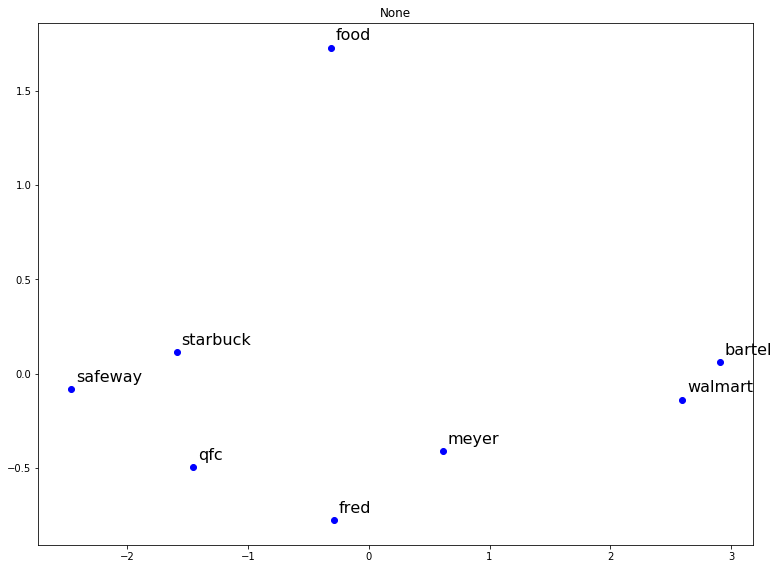

In [40]:
display_keywords_PCAscatterplot(model, 'starbuck')

['gated_commun', 'townhom', 'condominium', '2ba', '2bath', 'stori', 'bungalow', 'hollow']


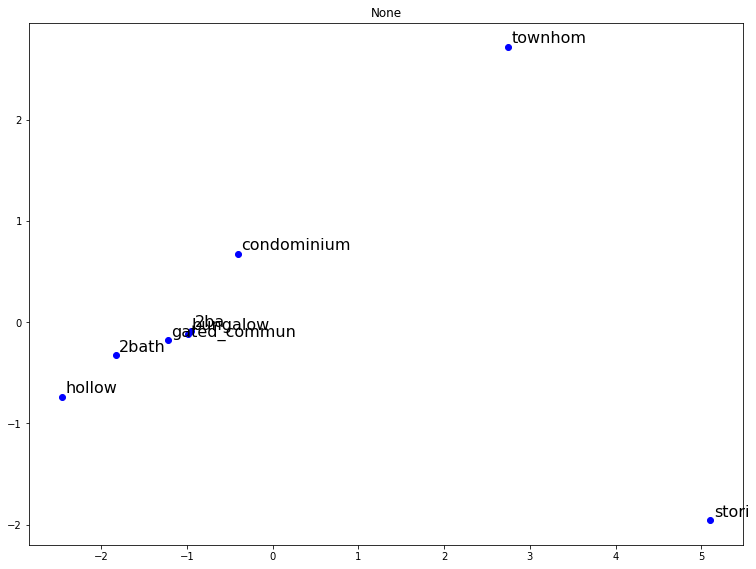

In [41]:
display_keywords_PCAscatterplot(model, 'gated_commun')

['crimin', 'convict', 'histori', 'refer', 'record', 'neg', 'evict', 'verif']


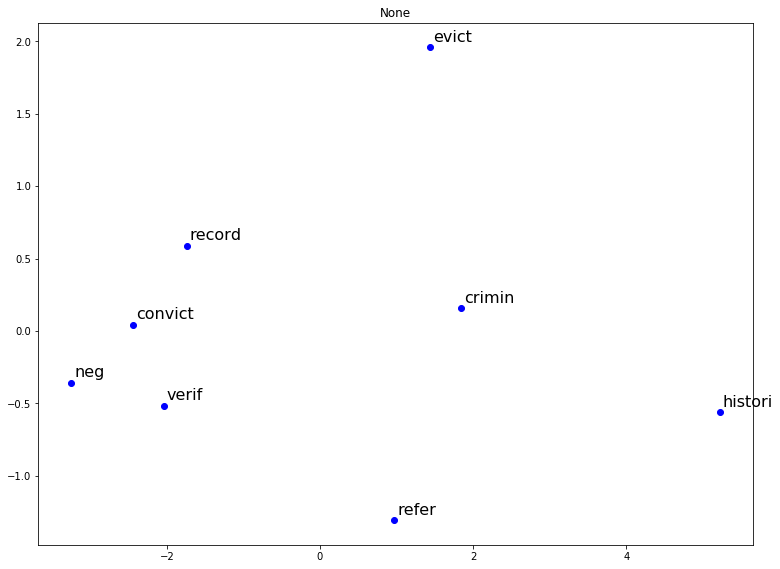

In [43]:
display_keywords_PCAscatterplot(model, 'crimin')